<a href="https://colab.research.google.com/github/screwspunner/jewel-type-detection/blob/main/mobilenetjewelsmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
import os
from PIL import Image
import numpy as np

In [ ]:
class JewelryDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpeg')]
        self.transform = transform
        self.labels = [os.path.basename(path).split('.')[0] for path in self.image_paths]  # Extract the label from filename

        # Apply one-hot encoding for labels
        self.encoder = OneHotEncoder()
        self.label_encodings = self.encoder.fit_transform(np.array(self.labels).reshape(-1, 1)).toarray()  # Convert to dense array

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.label_encodings[idx]  # One-hot encoded label

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/jewelrydataset'  # Update the path to your dataset folder

# Verify the files in the dataset folder
import os
print(os.listdir(dataset_path))  # List the contents of the dataset folder to check if the images are there

# Define transforms (Resize, ToTensor, Normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = JewelryDataset(dataset_path, transform=transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Verify the data is loaded correctly
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}, Batch labels shape: {labels.shape}")
    break  # Just print the first batch


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['FMB3826.jpeg', 'FMB3913.jpeg', 'FMB4885.jpeg', 'FMB3679.jpeg', 'FMB4511.jpeg', 'FMB3975.jpeg', 'FMB4444.jpeg', 'FMB3739.jpeg', 'FMB3940.jpeg', 'FMB4552.jpeg', 'FMB3726.jpeg', 'FMB3672.jpeg', 'FMB3805.jpeg', 'FMB4510.jpeg', 'FMB4809.jpeg', 'FMB4957- size - 16 - Colour - rose and white.jpeg', 'FMB3963.size 21. Rose gold.jpeg', 'FMB4548 size 19 . Rose gold.jpeg', "FMB4938 yellow gold size 19''.jpeg", 'FMB4549 size 21 Rose gold.jpeg', 'FMB4561 yellow gold size 18.jpeg', 'FMB3990 size 18 rose gold.jpeg', 'FMB3774 rose n white gold size 23.jpeg', 'FMB4501 yellow gold size 22.jpeg', 'FMB4964 size 16 yellow gold.jpeg', 'FMB4533 rose gold size 20.jpeg', 'FMB4954 size 17 yellow and white gold.jpeg', 'FMB3819 rose gold size 22.jpeg', 'FMB4517 size 21 Rose gold.jpeg', 'FMB3694 yellow gold size 20.jpeg', 'FMB4946 rose gold size 17.jpeg', 'FMB4408 yellow gold size 14.jpe

In [ ]:
# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze the layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes
num_classes = len(dataset.label_encodings[0])  # Number of unique classes (one-hot encoding length)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move the model to the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 54.3MB/s]


In [ ]:
# Set up the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy for multi-label classification
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/10], Loss: 0.492830784784423
Epoch [2/10], Loss: 0.21654454701476628
Epoch [3/10], Loss: 0.11379288509488106
Epoch [4/10], Loss: 0.07369732484221458
Epoch [5/10], Loss: 0.05486304871737957
Epoch [6/10], Loss: 0.044088149443268776
Epoch [7/10], Loss: 0.03710018636451827
Epoch [8/10], Loss: 0.03242725402944618
Epoch [9/10], Loss: 0.02881468108130826
Epoch [10/10], Loss: 0.02612907573994663


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving FMB3607 size 22 rose gold.jpeg to FMB3607 size 22 rose gold.jpeg


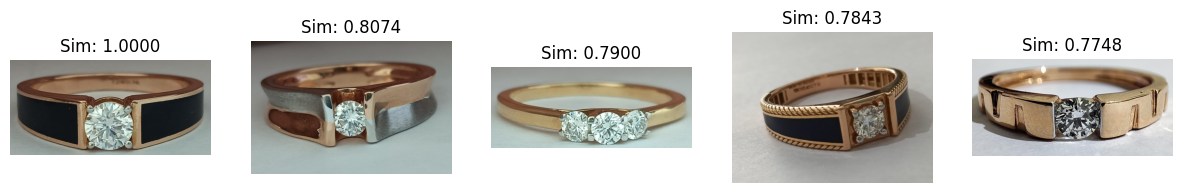

Match 1: /content/drive/MyDrive/jewelrydataset/FMB3607 size 22 rose gold.jpeg with Similarity: 1.0000
Match 2: /content/drive/MyDrive/jewelrydataset/FMB3802 size 20 white and rose gold.jpeg with Similarity: 0.8074
Match 3: /content/drive/MyDrive/jewelrydataset/FMB3662 size 16 yellow gold.jpeg with Similarity: 0.7900
Match 4: /content/drive/MyDrive/jewelrydataset/FMB4549 size 21 Rose gold.jpeg with Similarity: 0.7843
Match 5: /content/drive/MyDrive/jewelrydataset/fmb3727 rose gold size 20.jpeg with Similarity: 0.7748


In [ ]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from io import BytesIO

# 1. Load the pretrained MobileNetV2 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.mobilenet_v2(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# 2. Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size expected by MobileNetV2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3. Upload Query Image from local machine
def upload_query_image():
    uploaded = files.upload()  # This will allow you to upload an image from your local machine
    query_image_path = list(uploaded.keys())[0]
    query_image = Image.open(BytesIO(uploaded[query_image_path]))
    return query_image, query_image_path

query_image, query_image_path = upload_query_image()

# 4. Preprocess and extract features from the query image
query_image_tensor = transform(query_image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU/CPU
with torch.no_grad():
    query_features = model.features(query_image_tensor)  # Use the feature extractor part of MobileNetV2
    query_features = query_features.mean([2, 3])  # Global Average Pooling to reduce the spatial dimensions
query_features = query_features.squeeze().cpu().numpy()  # Convert to NumPy array and remove unnecessary dimensions

# 5. Compute similarity scores with all images in the dataset
image_paths = dataset.image_paths  # All image paths from the dataset (should be previously loaded in step 3)
image_features = []  # To store features of each image
for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.features(img_tensor)  # Extract features
        features = features.mean([2, 3])  # Global Average Pooling
    image_features.append(features.squeeze().cpu().numpy())  # Store flattened features

# 6. Calculate Cosine Similarity
query_features = query_features.reshape(1, -1)  # Reshape for similarity computation
similarities = cosine_similarity(query_features, image_features).flatten()  # Cosine similarity with all images

# 7. Get the top 5 most similar images
top_5_indices = similarities.argsort()[-5:][::-1]  # Indices of top 5 similar images
top_5_similarities = similarities[top_5_indices]  # Corresponding similarity scores

# 8. Display the top 5 images with similarity scores
plt.figure(figsize=(15, 10))
for i, idx in enumerate(top_5_indices):
    img_path = image_paths[idx]
    img = Image.open(img_path).convert("RGB")
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Sim: {top_5_similarities[i]:.4f}")
    plt.axis("off")

plt.show()

# 9. Print the paths and similarity scores of the top 5 matches
for i, idx in enumerate(top_5_indices):
    print(f"Match {i+1}: {image_paths[idx]} with Similarity: {top_5_similarities[i]:.4f}")


In [ ]:
# Specify the path to save the model in Google Drive
model_save_path = '/content/drive/MyDrive/mobilenet_jewels_model_v2_state_dict.pth'

# Save the model's state_dict to Google Drive
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully at {model_save_path}")

Model saved successfully at /content/drive/MyDrive/mobilenet_jewels_model_v2_state_dict.pth
